In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the image

In [ ]:
IMG_PATH = 'catTemp.png'
img = image.load_img(IMG_PATH, target_size=(224, 224))
# print(img)
plt.imshow(img)


In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array,axis=0)
img_preprocessed = preprocess_input(img_batch)


In [ ]:
model = tf.keras.applications.resnet50.ResNet50()
prediction = model.predict(img_preprocessed)
print(decode_predictions(prediction, top=3)[0])



# Cats and dogs

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

In [5]:
TRAIN_DATA_DIR = 'data/train/'
VALIDATION_DATA_DIR = 'data/val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 512 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


# Creating the model

In [8]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [ ]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

# Load the model

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model.h5')

# Prediction

In [14]:
img_path = 'cat.1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[9.9999392e-01 6.1252604e-06]]
{'cat': 0, 'dog': 1}


# Analysing the result

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform
import matplotlib.image as mpimg

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

with CustomObjectScope(
    {'GlorotUniform': glorot_uniform()}):
    model = load_model('model.h5')

In [19]:
predictions = model.predict_generator(validation_generator,
                                      steps=None)

# Get Images

In [25]:
ground_truth = validation_generator.classes
filenames = validation_generator.filenames


def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [21]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

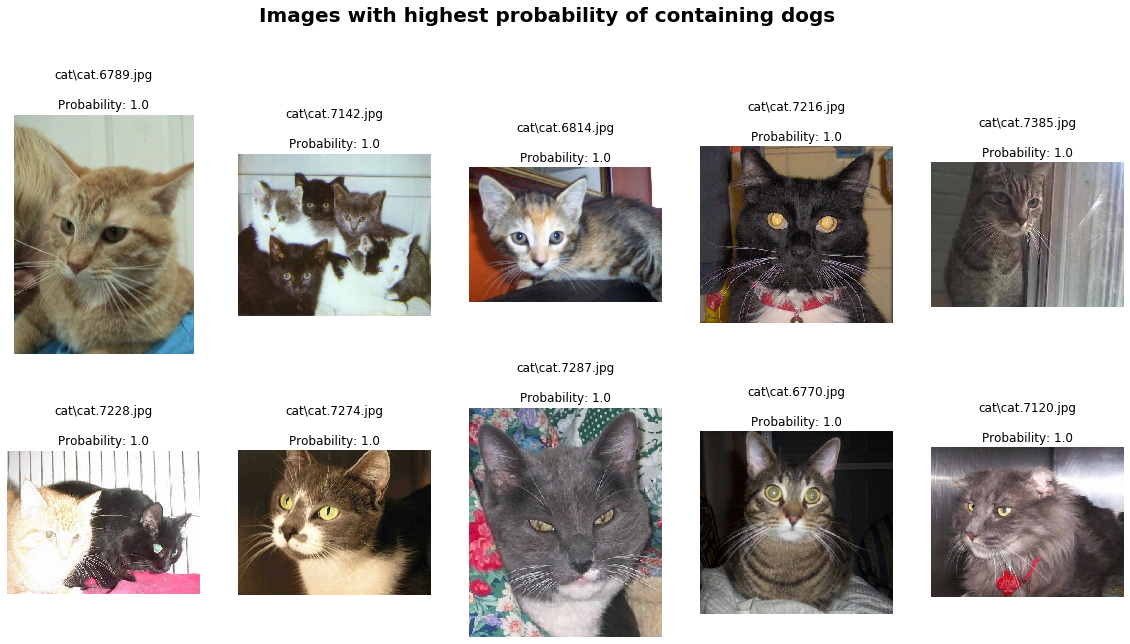

In [33]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)


# print(prediction_table)
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               False)
message = 'Images with highest probability of containing dogs'
display(most_confident_dog_images, message)